In [1]:
import os
import numpy as np
import torch
from torchsummary import summary
import copy
import matplotlib.pyplot as plt

import scipy.io.wavfile
import cupy as cp
from scipy import signal
from IPython.display import Audio

In [2]:
class data_from_dir(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_dir, resample=False):
        'Initialization'
        self.resample = resample
        self.file_dir = file_dir
        self.file_filenames = [ x for x in os.listdir(file_dir) ]
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_filenames)

    def __getitem__(self, index, resample=False):
        'Load one sample of data'
        # Select sample
        sr, wave = scipy.io.wavfile.read(os.path.join(self.file_dir, self.file_filenames[index]))
        if self.resample:
            # Let's resample and scale:
            target_length = 5 # seconds
            target_sr = 48000 # sampling rate, samples per second
            resampled_wave_cpu = scipy.signal.resample(wave, int(target_sr*target_length))
            resampled_wave = resampled_wave_cpu.astype(int)

#             wave_gpu = cp.asarray(wave)
#             resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
#             resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)
            scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)
            return scaled_wave.reshape(1, -1) # each element in array is one-dimensional, so need to reshape as 1-dimensional array
        else:
            return wave.reshape(1, -1)
            

In [3]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [4]:
%%time
dataset = data_from_dir("../data/dataset/resampled", resample=False) # load already prepared and resampled files
# dataset = data_from_dir("../data/dataset/25G_train", resample=False) # load already prepared and resampled files
# dataset = data_from_dir("../data/dataset/small", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(dataset))

# # check all files to be consistent before pass to neural network
# for index, wave in enumerate(dataset):
#     if len(wave[0]) != 240000:
#         print("Size error:     ", dataset.file_filenames[index])
#         print("Current length: ", len(dataset[index]))
#         break
# if index+1 == len(dataset):
#     print("All files consistent and have same length 240k amplitudes each")
# print()
# print()

# wave

Dataset size:  78057
CPU times: user 32.2 ms, sys: 20 ms, total: 52.2 ms
Wall time: 51.8 ms


In [5]:
%%time
# check one file in dataset to be sure everything is good:
file_number=7
wave = dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)


Type:               <class 'numpy.ndarray'>
Data:               [   184   -223  -1175 ...  -9500 -12318  -8393]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -29772
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 75.5 ms, sys: 0 ns, total: 75.5 ms
Wall time: 73.7 ms


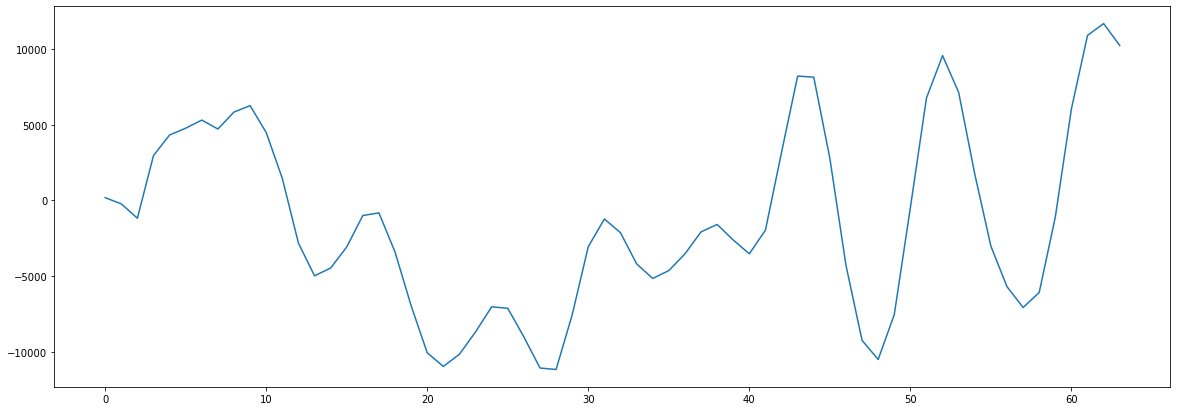

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
plt.plot(dataset[file_number][0][0:64]) # plotting by columns
plt.show()

In [7]:
%%time
print("Original source:")
sr, wave = scipy.io.wavfile.read(os.path.join("../data/sliced", dataset.file_filenames[file_number]))
Audio(wave, rate=sr)

Original source:
CPU times: user 3.92 ms, sys: 0 ns, total: 3.92 ms
Wall time: 3.19 ms


In [8]:
%%time
# now split whole dataset to train and test subsets
# get 50% for tests

# train_size = int(0.5 * len(dataset))
train_size = int(0.961 * len(dataset))
# train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Train dataset size: ", len(train_dataset))
print("Test dataset size:  ", len(test_dataset))
print()

Train dataset size:  75012
Test dataset size:   3045

CPU times: user 774 ms, sys: 3.99 ms, total: 778 ms
Wall time: 15 ms


In [9]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True) #, num_workers=4) # num_workers have an issue, not working
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True) #, num_workers=4)

CPU times: user 181 µs, sys: 1 µs, total: 182 µs
Wall time: 190 µs


In [10]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [11]:
# for idx, inputs in enumerate(train_loader):
#     None
# amplitude_range = 32767*2+1.0 # = 65535
# normalized = 0.5 + inputs/amplitude_range # [0..1]

In [12]:
# describe model architecture

class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        kernel_size_1 = int(64) # 128, stride=2, pool=2
        kernel_size_2 = int(25) # 25
        kernel_size_3 = int(16) # 9
        kernel_size_4 = int(8) # 5
        kernel_size_5 = int(8) # 5
        kernel_size_6 = int(4) # 5
        kernel_size_7 = int(3) # 5
        kernel_size_8 = int(3) # 5

        padding_1 = int(31) # 
        padding_2 = int(12) # 
        padding_3 = int(12) # 
        padding_4 = int(3) # 
        padding_5 = int(3) # 
        padding_6 = int(0) # 
        padding_7 = 0 # int((kernel_size_7 - 1)/2) # 
        padding_8 = int((kernel_size_8 - 1)/2) # 
        
        activation = torch.nn.LeakyReLU(0.1)

        # 240k - 9600 - 600 - 40 - 5 - 1
        # encoder
        # 240k -> 15000
        self.enc1co = torch.nn.Conv1d(1, 32, kernel_size=kernel_size_1, stride=8, padding=padding_1, bias=False)
        self.enc1bn = torch.nn.BatchNorm1d(32)
        self.enc1ac = activation
        self.enc1mp = torch.nn.MaxPool1d(kernel_size=4, stride=4, return_indices=True)

        # 15000 -> 1850
        self.enc2co = torch.nn.Conv1d(32, 64, kernel_size=kernel_size_2, stride=5, padding=padding_2, bias=False)
        self.enc2bn = torch.nn.BatchNorm1d(64)
        self.enc2ac = activation
        self.enc2mp = torch.nn.MaxPool1d(kernel_size=3, stride=3, return_indices=True)

        # 1850 -> 375
        self.enc3co = torch.nn.Conv1d(64, 128, kernel_size=kernel_size_3, stride=8, padding=padding_3, bias=False)
        self.enc3bn = torch.nn.BatchNorm1d(128)
        self.enc3ac = activation
#         self.enc3mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

        # 375 -> 75
        self.enc4co = torch.nn.Conv1d(128, 256, kernel_size=kernel_size_4, stride=4, padding=padding_4, bias=False)
        self.enc4bn = torch.nn.BatchNorm1d(256)
        self.enc4ac = activation
#         self.enc4mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

        # 75 -> 15
        self.enc5co = torch.nn.Conv1d(256, 512, kernel_size=kernel_size_5, stride=4, padding=padding_5, bias=False)
        self.enc5bn = torch.nn.BatchNorm1d(512)
        self.enc5ac = activation
#         self.enc5mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

        # 15 -> 3
        self.enc6co = torch.nn.Conv1d(512, 1024, kernel_size=kernel_size_6, stride=4, padding=padding_6, bias=False)
        self.enc6bn = torch.nn.BatchNorm1d(1024)
        self.enc6ac = activation
#         self.enc6mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

        # 3 -> 1
        self.enc7co = torch.nn.Conv1d(512, 512, kernel_size=kernel_size_7, stride=3, padding=padding_7, bias=False)
#         self.enc7bn = torch.nn.BatchNorm1d(512)
        self.enc7ac = activation
#         self.enc7mp = torch.nn.MaxPool1d(kernel_size=3, stride=3, return_indices=True)

#         # 2 -> 1
#         self.enc8co = torch.nn.Conv1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
#         self.enc8bn = torch.nn.BatchNorm1d(512)
#         self.enc8ac = torch.nn.ReLU()
#         self.enc8mp = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)

#         # decoder 
#         self.dec8mup = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
#         self.dec8uco = torch.nn.ConvTranspose1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
#         self.dec8bn = torch.nn.BatchNorm1d(512)
#         self.dec8ac = torch.nn.ReLU()
        
#         self.dec7mup = torch.nn.MaxUnpool1d(kernel_size=3, stride=3)
        self.dec7uco = torch.nn.ConvTranspose1d(512, 512, kernel_size=kernel_size_7, stride=3, padding=padding_7, bias=False)
        self.dec7bn = torch.nn.BatchNorm1d(512)
        self.dec7ac = activation
        
#         self.dec6mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec6uco = torch.nn.ConvTranspose1d(1024, 512, kernel_size=kernel_size_6, stride=4, padding=padding_6, bias=False)
        self.dec6bn = torch.nn.BatchNorm1d(512)
        self.dec6ac = activation

#         self.dec5mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec5uco = torch.nn.ConvTranspose1d(512, 256, kernel_size=kernel_size_5, stride=4, padding=padding_5-1, bias=False)
        self.dec5bn = torch.nn.BatchNorm1d(256)
        self.dec5ac = activation
        
#         self.dec4mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec4uco = torch.nn.ConvTranspose1d(256, 128, kernel_size=kernel_size_4, stride=4, padding=padding_4-1, bias=False)
        self.dec4bn = torch.nn.BatchNorm1d(128)
        self.dec4ac = activation

#         self.dec3mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec3uco = torch.nn.ConvTranspose1d(128, 64, kernel_size=kernel_size_3, stride=8, padding=padding_3-2, bias=False)
        self.dec3bn = torch.nn.BatchNorm1d(64)
        self.dec3ac = activation

        self.dec2mup = torch.nn.MaxUnpool1d(kernel_size=3, stride=3)
        self.dec2uco = torch.nn.ConvTranspose1d(64, 32, kernel_size=kernel_size_2, stride=5, padding=padding_2-2, bias=False)
        self.dec2bn = torch.nn.BatchNorm1d(32)
        self.dec2ac = activation
        
        self.dec1mup = torch.nn.MaxUnpool1d(kernel_size=4, stride=4)
        self.dec1uco = torch.nn.ConvTranspose1d(32, 1, kernel_size=kernel_size_1, stride=8, padding=padding_1-3, bias=False)
        self.dec1bn = torch.nn.BatchNorm1d(1)
        self.dec1ac = torch.nn.Sigmoid() # data range will be transformed to [0..1]
        
        # now initialize weights
        torch.nn.init.kaiming_uniform_(self.enc1co.weight)
        torch.nn.init.kaiming_uniform_(self.enc2co.weight)
        torch.nn.init.kaiming_uniform_(self.enc3co.weight)
        torch.nn.init.kaiming_uniform_(self.enc4co.weight)
        torch.nn.init.kaiming_uniform_(self.enc5co.weight)
        torch.nn.init.kaiming_uniform_(self.enc6co.weight)
        torch.nn.init.kaiming_uniform_(self.enc7co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc8co.weight)
        torch.nn.init.kaiming_uniform_(self.dec1uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec2uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec3uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec4uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec5uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec6uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec7uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec8uco.weight)


    def forward(self, x):
#         print(x.shape)
        x = self.enc1co(x)
        x = self.enc1bn(x)
        x = self.enc1ac(x)
        x,self.idx1 = self.enc1mp(x)
#         print(x.shape)
        x = self.enc2co(x)
        x = self.enc2bn(x)
        x = self.enc2ac(x)
        x,self.idx2 = self.enc2mp(x)
#         print(x.shape)
        x = self.enc3co(x)
        x = self.enc3bn(x)
        x = self.enc3ac(x)
#         print(x.shape)
#         x,self.idx3 = self.enc3mp(x)
        x = self.enc4co(x)
        x = self.enc4bn(x)
        x = self.enc4ac(x)
#         print(x.shape)
#         x,self.idx4 = self.enc4mp(x)
        x = self.enc5co(x)
        x = self.enc5bn(x)
        x = self.enc5ac(x)
#         print(x.shape)
#         x,self.idx5 = self.enc5mp(x)
        x = self.enc6co(x)
        x = self.enc6bn(x)
        x = self.enc6ac(x)
#         print(x.shape)
#         x,self.idx6 = self.enc6mp(x)
#         x = self.enc7co(x)
#         x = self.enc7bn(x)
#         x = self.enc7ac(x)
#         x,self.idx7 = self.enc7mp(x)
#         x = self.enc8co(x)
#         x = self.enc8bn(x)
#         x = self.enc8ac(x)
#         x,self.idx8 = self.enc8mp(x)

#         x = self.dec8mup(x, self.idx8)
#         x = self.dec8uco(x)
#         x = self.dec8bn(x)
#         x = self.dec8ac(x)
#         x = self.dec7mup(x, self.idx7)
#         x = self.dec7uco(x)
#         x = self.dec7bn(x)
#         x = self.dec7ac(x)
#         x = self.dec6mup(x, self.idx6)
        x = self.dec6uco(x)
        x = self.dec6bn(x)
        x = self.dec6ac(x)
#         print(x.shape)
#         x = self.dec5mup(x, self.idx5)
        x = self.dec5uco(x)
        x = self.dec5bn(x)
        x = self.dec5ac(x)
#         print(x.shape)
#         x = self.dec4mup(x, self.idx4)
        x = self.dec4uco(x)
        x = self.dec4bn(x)
        x = self.dec4ac(x)
#         print(x.shape)
#         x = self.dec3mup(x, self.idx3)
        x = self.dec3uco(x)
        x = self.dec3bn(x)
        x = self.dec3ac(x)
#         print(x.shape)
        x = self.dec2mup(x, self.idx2)
        x = self.dec2uco(x)
        x = self.dec2bn(x)
        x = self.dec2ac(x)
#         print(x.shape)
        x = self.dec1mup(x, self.idx1)
        x = self.dec1uco(x)
        x = self.dec1bn(x)
        x = self.dec1ac(x)
#         print(x.shape)

        return x

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder()
model.cuda() # need to be set to cuda to get summary working

model_path = "../models/ConvAutoEncoder.full.000-0.000-0..model.pt"
loaded_model = torch.load(model_path, map_location=device)
model = loaded_model

summary(model, (1, 240000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 30000]           2,048
       BatchNorm1d-2            [-1, 32, 30000]              64
         LeakyReLU-3            [-1, 32, 30000]               0
         MaxPool1d-4  [[-1, 32, 7500], [-1, 32, 7500]]               0
            Conv1d-5             [-1, 64, 1500]          51,200
       BatchNorm1d-6             [-1, 64, 1500]             128
         LeakyReLU-7             [-1, 64, 1500]               0
         MaxPool1d-8  [[-1, 64, 500], [-1, 64, 500]]               0
            Conv1d-9              [-1, 128, 64]         131,072
      BatchNorm1d-10              [-1, 128, 64]             256
        LeakyReLU-11              [-1, 128, 64]               0
           Conv1d-12              [-1, 256, 16]         262,144
      BatchNorm1d-13              [-1, 256, 16]             512
        LeakyReLU-14       

In [35]:
# train on cuda if available
# torch.cuda.empty_cache()
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model(model, criterion, optimizer, num_epochs=10, early_stop_loss=1e-5):
    liveloss = PlotLosses()
    model = model.to(device)
    amplitude_range = 32767*2 + 1.0 # = 65535
    arr_logs = []
    
    for epoch_id, epoch in enumerate(range(num_epochs)):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = inputs.to(device, dtype=torch.float)
                inputs = 0.5 + (inputs/amplitude_range) # [0..1]
                outputs = model(inputs)
                loss = (criterion(outputs, inputs))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.detach() * inputs.size(0)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)           
            prefix = ''
            if phase == 'test':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item()
        
        if len(arr_logs) < 100:
            arr_logs.append(logs)
        else:
            arr_logs.pop(0)
            arr_logs.append(logs)
        liveloss = PlotLosses()
        for j in arr_logs:
            liveloss.update(j)
        liveloss.send()
        print(f"\n[{epoch_id+1}/{num_epochs}]    {logs}")
        if epoch_loss.item() <= early_stop_loss:
            break
    print("\nTrained.")

In [49]:
torch.cuda.empty_cache()
# model = ConvAutoencoder()
criterion = torch.nn.MSELoss()
# criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001) # [0.001 .. 0.0005 ... 0.0001] 0.001 per 10 epochs & 0.00001 per 1000 epochs

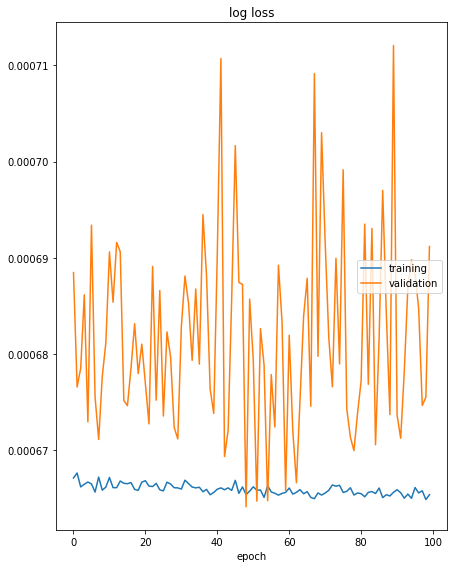

log loss
	training         	 (min:    0.001, max:    0.001, cur:    0.001)
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)

[100/100]    {'log loss': 0.0006653398158960044, 'val_log loss': 0.0006911637610755861}

Trained.
CPU times: user 10h 32min 13s, sys: 12h 55min 56s, total: 23h 28min 10s
Wall time: 7h 52min 32s


In [50]:
%%time
train_model(model, criterion, optimizer, num_epochs=100) # start @ 10:35:30

In [51]:
validation_dataset = data_from_dir("../data/dataset/test", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(validation_dataset))

Dataset size:  524


In [71]:
%%time
# check one file in dataset to be sure everything is good:
file_number=100
wave = validation_dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)

Type:               <class 'numpy.ndarray'>
Data:               [ -407 -1916 -1966 ... 11730  7021  2694]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -26640
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 0 ns, sys: 72.3 ms, total: 72.3 ms
Wall time: 69.8 ms


In [72]:
wave = validation_dataset[file_number][0]
amplitude_range = 32767*2+1.0 # = 65535
inputs = torch.Tensor([[0.5 + wave/amplitude_range]]) # [0..1]
inputs = inputs.to(device)
outputs = model(inputs)
loss = (criterion(outputs, inputs))
print(f"loss: {loss.item()}")
result = np.int16(((outputs - 0.5)*(amplitude_range-1)).detach().cpu())
Audio(result[0][0], rate=sr)

loss: 0.0006765456055290997


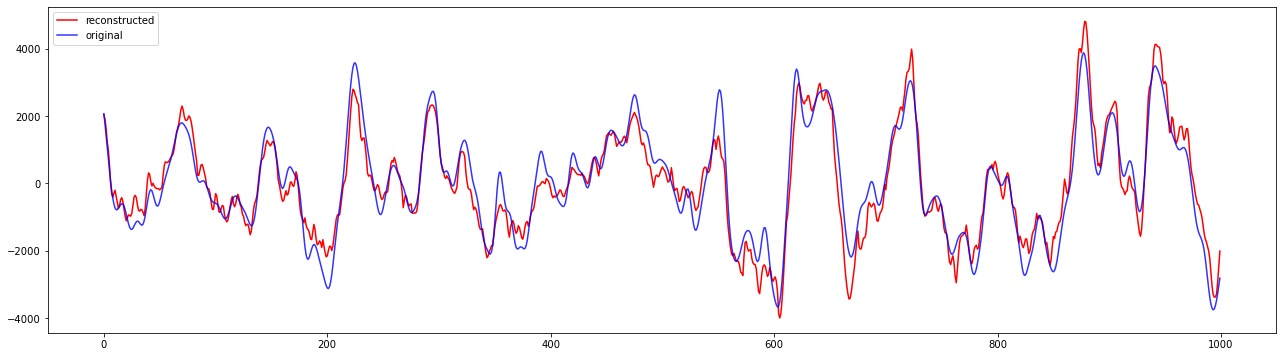

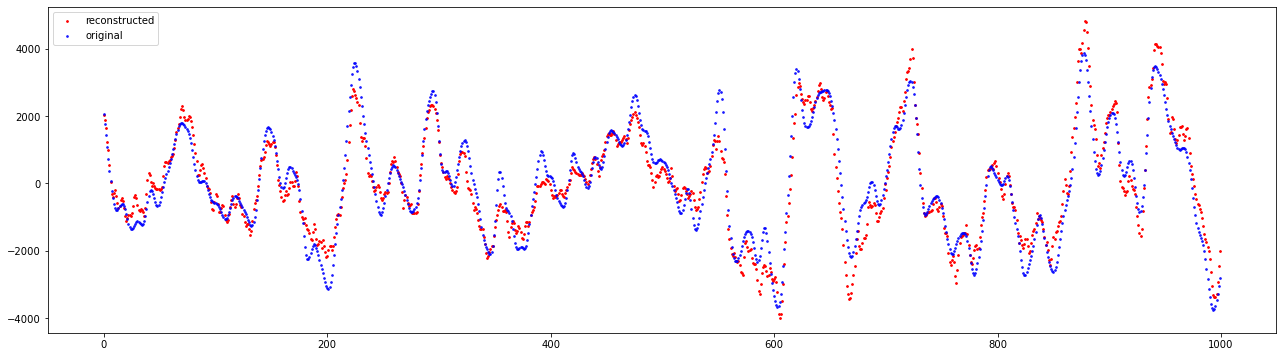

In [73]:
amp_start = 1000
amp_end =   2000
plt.figure(figsize=(22,6))
plt.plot(result[0][0][amp_start:amp_end], linestyle="-", color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.plot(wave[amp_start:amp_end], linestyle="-", color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(22,6))
x = np.arange(0, amp_end-amp_start)
plt.scatter(x, result[0][0][amp_start:amp_end], s=3, color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.scatter(x, wave[amp_start:amp_end], s=3, color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

In [58]:
model_path = "../models/ConvAutoEncoder.full.665-4.691-4.best.model.pt"
torch.save(model, model_path)
os.chown(model_path, 1000, 1000)

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loaded_model = torch.load(model_path, map_location=device)

In [23]:
summary(loaded_model, (1, 240000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 30000]           2,048
       BatchNorm1d-2            [-1, 32, 30000]              64
         LeakyReLU-3            [-1, 32, 30000]               0
         MaxPool1d-4  [[-1, 32, 7500], [-1, 32, 7500]]               0
            Conv1d-5             [-1, 64, 1500]          51,200
       BatchNorm1d-6             [-1, 64, 1500]             128
         LeakyReLU-7             [-1, 64, 1500]               0
         MaxPool1d-8  [[-1, 64, 500], [-1, 64, 500]]               0
            Conv1d-9              [-1, 128, 64]         131,072
      BatchNorm1d-10              [-1, 128, 64]             256
        LeakyReLU-11              [-1, 128, 64]               0
           Conv1d-12              [-1, 256, 16]         262,144
      BatchNorm1d-13              [-1, 256, 16]             512
        LeakyReLU-14       

In [24]:
loaded_model

ConvAutoencoder(
  (enc1co): Conv1d(1, 32, kernel_size=(64,), stride=(8,), padding=(31,), bias=False)
  (enc1bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc1ac): LeakyReLU(negative_slope=0.1)
  (enc1mp): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (enc2co): Conv1d(32, 64, kernel_size=(25,), stride=(5,), padding=(12,), bias=False)
  (enc2bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc2ac): LeakyReLU(negative_slope=0.1)
  (enc2mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (enc3co): Conv1d(64, 128, kernel_size=(16,), stride=(8,), padding=(12,), bias=False)
  (enc3bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3ac): LeakyReLU(negative_slope=0.1)
  (enc4co): Conv1d(128, 256, kernel_size=(8,), stride=(4,), padding=(3,), bias=False)
  (enc4bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=T